The task in this notebook is to train a network which, given an image of a star, will calculate both the number of points on the star, as well as its width.

Thus this will be a multi-task network, performing two completely different tasks simultaneously.


In [ ]:
#%% import stuff:

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn

The cell below assumes you have already downloaded the dataset from brightspace, and put it in your google drive folder. It demonstrates how to use google drive together with a colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


temp=pickle.load(open('/content/drive/MyDrive/starData.p','rb'))
X=temp['X']
y=temp['y']


Mounted at /content/drive


tensor([6.0000, 2.5596])


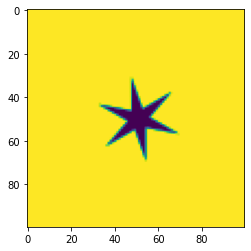

In [ ]:
#Let's plot an example
idx=125
plt.imshow(np.squeeze(X[125,:,:,:],axis=0))
print(y[idx,:]) #first column is number of points, second is size of the star

In [ ]:
#%% make datasets & loaders

#split in val and train

#make datasets (TensorDataset will do)

#make dataloaders


In [ ]:
#%% make network

#something simple like cnn-cnn-fc-relu-fc will do



#testing:
testData=torch.rand((1,1,100,100))
testNet=someNetwork()
testNet.forward(testData)

In [ ]:
#%% define loss'es
loss1=?
loss2=?
loss_fn = #some combination of loss1 and loss2

In [ ]:
#%% train & validate

nEpoch=?

net=someNetwork()
optimizer=?


for iEpoch in range(nEpoch):

    totLoss=0
    for xbatch,ybatch in trainLoader:

        the usual. pass the output of your network to the custom loss function you made above
        use it to update the weights


    for xbatch,ybatch in valLoader:
        remember to watch the loss on the validation data




In [ ]:
#evaluate

try plotting predictions vs. targets for both training data and validation data in a scatterplot, and see how much variation you've captured